<a href="https://colab.research.google.com/github/zackives/upenn-cis-2450/blob/main/Lab_PyTorch_and_Neural_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 2450 Lab 9 - PyTorch and Neural Networks

## Dependency Loading

In [ ]:
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

print(torch.__version__)

2.5.1+cu121


## A Brief Tutorial on PyTorch


### Making sure a GPU is available.

Part of what we'll be doing in this tutorial is covering using GPUs for computation in PyTorch. In order to enable the use of a GPU in colab, you'll first need to go to `Runtime -> Change runtime type` in the menu system above. Then, under hardware acceleration, choose GPU.

Once you've done that, the next cell should run without errors.

In [ ]:
# TODO: Running this cell shouldn't produce an error if you've done the above steps correctly.
assert torch.cuda.is_available()

### Understanding Tensors

Tensors in PyTorch are direct equivalents of `ndarray` (or just arrays) in NumPy in many ways. In fact, many of the operations you are now familiar with in numpy translate directly over to PyTorch! Below are some examples.

In [ ]:
# TODO: Make a 5x5 matrix, a 5x1 column vector, a 1x5 row vector and a (5,) "proper" vector in NumPy and PyTorch
np_vec = np.arange(1, 6)  # (5,)
np_rvec = np_vec[None, :]  # (1, 5)
np_cvec = np_vec[:, None]  # (5, 1)
np_mat = np.tile(np_rvec, (5, 1))  # Repeat the np_rvec row 5 times --> (5, 5)
print(np_vec.shape, np_rvec.shape, np_cvec.shape, np_mat.shape)

th_vec = torch.arange(1, 6)
th_rvec = th_vec[None, :]  # Or: th_vec.unsqueeze(0)
th_cvec = th_vec[:, None]  # Or: th_vec.unsqueeze(1)
th_mat = torch.tile(th_rvec, (5, 1))
print(th_vec.shape, th_rvec.shape, th_cvec.shape, th_mat.shape)

print('NumPy matrix...')
print(np_mat)
print('Torch matrix...')
print(th_mat)

(5,) (1, 5) (5, 1) (5, 5)
torch.Size([5]) torch.Size([1, 5]) torch.Size([5, 1]) torch.Size([5, 5])
NumPy matrix...
[[1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]]
Torch matrix...
tensor([[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5]])


In [ ]:
# As a reminder, here are some operations you can do in NumPy on matrices and vectors.

# Matrix vector multiplication
np_mvm = np_mat @ np_cvec  # or np.matmul

# Add np_rvec to each row of np_mat
np_add1 = np_mat + np_rvec

# Subtract np_cvec from each column of np_mat
np_add2 = np_mat - np_cvec

# Take the square root of each element of np_mat
np_sqrt = np.sqrt(np_mat)

In [ ]:
# TODO: Replicate the above operations on the PyTorch operations.

# Matrix vector multiplication
th_mvm = th_mat @ th_cvec  # or torch.matmul

# Add np_rvec to each row of np_mat
th_add1 = th_mat + th_rvec

# Subtract np_cvec from each column of np_mat
th_add2 = th_mat - th_cvec

# Take the square root of each element of np_mat
th_sqrt = torch.sqrt(th_mat)

### Difference 1: GPU Computing

The first major difference between numpy and pytorch is that pytorch supports easy use of GPUs for computation. The way this works is as follows:

1. First, move any tensors that you want to do computation on the GPU with to the GPU. This can be accomplished by calling either `gpu_tensor = tensor.cuda()` or `gpu_tensor = tensor.to('cuda')`. If you have more than one GPU on your computer, you can also specify which GPU to use, e.g. `tensor.to('cuda:1')`. Note that this will fail if you don't have a GPU available.
1. There is no step 2! Do computation with the tensors as normal and it all happens on the GPU.

In [ ]:
# TODO: Make a random 5000x5000 matrix in torch and do a matrix multiply with a 1000x1000 matrix of all ones.
# Hint: use torch.rand(n, m) and torch.ones(n, m)

th_mat1 = torch.rand(5000, 5000)
th_mat2 = torch.ones(5000, 5000)

In [ ]:
# TODO: Time a matrix multiply on the CPU

%time res = th_mat1 @ th_mat2

CPU times: user 1.87 s, sys: 77.4 ms, total: 1.95 s
Wall time: 1.94 s


In [ ]:
# TODO: Make new tensors Move th_mat1 and th_mat2 to the GPU
th_mat1_gpu = th_mat1.cuda()
th_mat2_gpu = th_mat2.cuda()

In [ ]:
%%time

# TODO: Fill in "res" below.

res = th_mat1_gpu @ th_mat2_gpu

print(res[0, 0])

tensor(2471.5098, device='cuda:0')
CPU times: user 82.5 ms, sys: 7.86 ms, total: 90.4 ms
Wall time: 90.4 ms


### Difference 2: Autograd

The second major difference between numpy and pytorch is that pytorch supports automatic differentiation. What this means is that pytorch allows you to do computation and get derivatives for free! Here's the basic work flow:

1. Define a Parameter with `some_param = torch.nn.Parameter(some_tensor)`.
1. Use the parameter in some computation.
1. Call `.backward()` on any scalar result of the computation to get derivatives for some_param in `some_param.grad`

In [ ]:
some_tensor = torch.rand(1)
# TODO: Make a parameter out of some_param
some_param = torch.nn.Parameter(some_tensor)

# TODO: Compute sin(exp(some_param)) and the derivative of sin(exp(x)) with respect to some_param.
# Hint: Use torch.sin and torch.exp
res = torch.sin(torch.exp(some_param))
res.backward()

print(res, some_param.grad)

tensor([0.9974], grad_fn=<SinBackward0>) tensor([0.1082])


Of course, autograd works for multivariate calculus, too. Let's compute the partial derivatives of the following 5 dimensional function: $$f(\mathbf{x}) = \sum_{i=1}^{5} \sin ( \exp (x_i) )$$ at a few inputs. E.g., we're going to compute $\frac{\partial f}{\partial x_i}$ for all i.

In [ ]:
# TODO: Make a random parameter of length 5.
param = torch.nn.Parameter(torch.rand(5,))
res = torch.sum(torch.sin(torch.exp(param)))
res.backward()

print(res, param.grad)

tensor(4.7513, grad_fn=<SumBackward0>) tensor([-1.2702,  0.2369, -0.3786, -0.1572, -0.3675])


## Building Block of ML #1: torch.nn.Module

In PyTorch, I can define Modules. Modules do two things for me:

1. They make it easy to collect a set of parameters together. By calling `module.parameters()` or `module.named_parameters()` I get a generator over the parameters not only of the module but all of its submodules.
2. They let me define a method called `forward` that gets called when I do `module(x)`.

Let's first code up a "from scratch" implementation of a module that might be useful for linear regression. To do this, we need to create a class that extends `Module`, defines `weight` and `bias` parameters in the constructor, and then defines a `forward` method that applies the familiar linear regression prediction equation, $w^{\top}x + b$

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim):
        """
        Args:
            input_dim: The number of features we expect in the dataset.
        """
        super().__init__()
        # TODO: Add a "weight" and "bias" parameter to this class.
        self.weight = torch.nn.Parameter(torch.rand(input_dim, 1))
        self.bias = torch.nn.Parameter(torch.rand(1, 1))

    def forward(self, x):
        # Assume: x is (n, d)
        # TODO: compute linear regression predictions for each x using the parameters you define above.
        prediction = (x @ self.weight) + self.bias
        return prediction

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True)
# X = StandardScaler().fit_transform(X, y)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33)

train_x, train_y = torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float()
test_x, test_y = torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float()

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([296, 10]) torch.Size([296]) torch.Size([146, 10]) torch.Size([146])


In [ ]:
# TODO: Make a new LinearRegression object with appropriate input_dim for the above dataset.
# Then, make predictions on train_x, and compute the derivative of the MSE with respect to your weight and bias.

linear_reg = LinearRegression(input_dim=10)
pred = linear_reg(train_x)
mse = torch.mean((pred - train_y) ** 2)
mse.backward()
print(linear_reg.weight.grad, linear_reg.bias.grad)

tensor([[ 0.3500],
        [-0.2256],
        [ 0.4917],
        [ 0.3808],
        [ 0.1731],
        [ 0.1798],
        [-0.3102],
        [ 0.1681],
        [ 0.2910],
        [ 0.6820]]) tensor([[-298.1755]])


## Building Block of ML #2: torch.optim

We're clearly making progress! So far, what we've been able to do is define a linear regression module with appropriate parameters, compute a loss function (mean squared error), and compute the derivative of the loss with respect to the weight and bias. All we need now is a way to apply these gradients to the parameters to update them and learn.

To help accomplish this, PyTorch provides a `torch.optim` library with a variety of `Optimizers`. In PyTorch, an `Optimizer` has the following properties:

1. You create an optimizer with a list (or generator) of parameters to optimize, and typically a learning rate / step size.
1. Optimizers expose a `zero_grad()` method that resets the gradients of all parameters to zero.
1. Optimizers expose a `step()` method that, if all parameters have had gradients filled in, applies a step of optimization with those gradients.

Below, we'll be using one optimizer called Adam, which is provided via `torch.optim.Adam`.

In [ ]:
# TODO: Use a torch.optim.Adam object to take a single step of learning on the MSE of our linear regressor above.
# Hint: Creating an Adam object can be done with torch.optim.Adam(some_parameters, lr=0.01)
# An optimization loop should: (1) zero the gradients, (2) compute the loss, (3) call backward, (4) call step.

opt = torch.optim.Adam(linear_reg.parameters(), lr=0.01)
opt.zero_grad()
pred = linear_reg(train_x)
loss = torch.mean((pred - train_y) ** 2)
loss.backward()
opt.step()

In [ ]:
# TODO: Train the linear regression model for 2500 iterations, and print out the loss every 100 iterations.

linear_reg = LinearRegression(input_dim=10)
opt = torch.optim.Adam(linear_reg.parameters(), lr=0.1)

for i in range(2500):
    opt.zero_grad()
    pred = linear_reg(train_x)
    loss = torch.mean((pred.squeeze() - train_y) ** 2)
    if i % 100 == 0:
        print(f'Iteration {i} - Loss = {loss:.2f}')
    loss.backward()
    opt.step()

Iteration 0 - Loss = 28073.16
Iteration 100 - Loss = 25019.52
Iteration 200 - Loss = 22264.28
Iteration 300 - Loss = 19788.79
Iteration 400 - Loss = 17571.98
Iteration 500 - Loss = 15594.17
Iteration 600 - Loss = 13837.12
Iteration 700 - Loss = 12283.52
Iteration 800 - Loss = 10916.75
Iteration 900 - Loss = 9720.79
Iteration 1000 - Loss = 8680.19
Iteration 1100 - Loss = 7780.15
Iteration 1200 - Loss = 7006.50
Iteration 1300 - Loss = 6345.82
Iteration 1400 - Loss = 5785.37
Iteration 1500 - Loss = 5313.22
Iteration 1600 - Loss = 4918.20
Iteration 1700 - Loss = 4589.94
Iteration 1800 - Loss = 4318.92
Iteration 1900 - Loss = 4096.44
Iteration 2000 - Loss = 3914.67
Iteration 2100 - Loss = 3766.62
Iteration 2200 - Loss = 3646.18
Iteration 2300 - Loss = 3548.07
Iteration 2400 - Loss = 3467.81


In [ ]:
# TODO: Compute test predictions and test MSE
pred = linear_reg(test_x)
test_error = torch.mean((pred.squeeze() - test_y) ** 2)
print(test_error)

tensor(3498.4475, grad_fn=<MeanBackward0>)


## torch.nn: A convenient library of pre baked modules.

torch.nn contains much more than just `Parameter` and `Module`: it contains a variety of pre baked modules that are useful for machine learning, including:
- `torch.nn.Linear`: Has weight and bias parameters, and applies an affine transformation $XW + b$ to an input.
- `torch.nn.ReLU`: Applies the rectified linear unit (ReLU) to the input.
- `torch.nn.Conv2d`: Applies 2D convolutions.
- `torch.nn.MaxPool2d`: Applies max pooling.

And many more! Let's use these to build a simple 1 hidden layer neural network on the boston data above.

In [ ]:
# Repeat the above linear regression, but using a torch.nn.Linear module instead of our "from scratch" version.

linear_reg = torch.nn.Linear(in_features=10, out_features=1)
opt = torch.optim.Adam(linear_reg.parameters(), lr=0.1)

for i in range(2500):
    opt.zero_grad()
    pred = linear_reg(train_x)
    loss = torch.mean((pred.squeeze() - train_y) ** 2)
    if i % 100 == 0:
        print(f'Iteration {i} - Loss = {loss:.2f}')
    loss.backward()
    opt.step()

Iteration 0 - Loss = 28277.63
Iteration 100 - Loss = 25210.38
Iteration 200 - Loss = 22441.62
Iteration 300 - Loss = 19952.80
Iteration 400 - Loss = 17722.96
Iteration 500 - Loss = 15732.45
Iteration 600 - Loss = 13963.05
Iteration 700 - Loss = 12397.53
Iteration 800 - Loss = 11019.33
Iteration 900 - Loss = 9812.47
Iteration 1000 - Loss = 8761.57
Iteration 1100 - Loss = 7851.86
Iteration 1200 - Loss = 7069.24
Iteration 1300 - Loss = 6400.28
Iteration 1400 - Loss = 5832.27
Iteration 1500 - Loss = 5353.28
Iteration 1600 - Loss = 4952.13
Iteration 1700 - Loss = 4618.45
Iteration 1800 - Loss = 4342.68
Iteration 1900 - Loss = 4116.10
Iteration 2000 - Loss = 3930.83
Iteration 2100 - Loss = 3779.85
Iteration 2200 - Loss = 3656.98
Iteration 2300 - Loss = 3556.88
Iteration 2400 - Loss = 3475.02


In [ ]:
# Compute test predictions and test MSE
pred = linear_reg(test_x)
test_error = torch.mean((pred.squeeze() - test_y) ** 2)
print(test_error)

tensor(3505.4338, grad_fn=<MeanBackward0>)


In [ ]:
# Make a feed forward neural network Module with one hidden layer.

class NeuralNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # First layer: map from input to hidden features.
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)

        # Second layer: map from hidden dim to prediction size (1)
        self.linear2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        hidden_feat = self.linear1(x)
        hidden_feat = torch.relu(hidden_feat)
        prediction = self.linear2(hidden_feat)
        return prediction

In [ ]:
# TODO: Make a neural network with a hidden dimensionality of 64.
# Then, train the neural network using Adam for 5000 iterations using a learning rate of 0.01.
# Print the loss every 100 iterations.

neural_net = NeuralNet(input_dim=10, hidden_dim=64)
opt = torch.optim.Adam(neural_net.parameters(), lr=0.01)

for i in range(5000):
    opt.zero_grad()
    pred = neural_net(train_x)
    loss = torch.mean((pred.squeeze() - train_y) ** 2)
    if i % 100 == 0:
        print(f'Iteration {i} - Loss = {loss:.2f}')
    loss.backward()
    opt.step()

Iteration 0 - Loss = 28252.36
Iteration 100 - Loss = 11779.49
Iteration 200 - Loss = 3512.03
Iteration 300 - Loss = 3149.74
Iteration 400 - Loss = 3000.32
Iteration 500 - Loss = 2930.91
Iteration 600 - Loss = 2894.72
Iteration 700 - Loss = 2874.57
Iteration 800 - Loss = 2862.88
Iteration 900 - Loss = 2855.73
Iteration 1000 - Loss = 2851.04
Iteration 1100 - Loss = 2847.67
Iteration 1200 - Loss = 2845.02
Iteration 1300 - Loss = 2842.73
Iteration 1400 - Loss = 2840.61
Iteration 1500 - Loss = 2838.56
Iteration 1600 - Loss = 2836.54
Iteration 1700 - Loss = 2834.51
Iteration 1800 - Loss = 2832.49
Iteration 1900 - Loss = 2830.46
Iteration 2000 - Loss = 2828.45
Iteration 2100 - Loss = 2826.45
Iteration 2200 - Loss = 2824.48
Iteration 2300 - Loss = 2822.54
Iteration 2400 - Loss = 2820.64
Iteration 2500 - Loss = 2818.79
Iteration 2600 - Loss = 2817.00
Iteration 2700 - Loss = 2815.28
Iteration 2800 - Loss = 2813.63
Iteration 2900 - Loss = 2812.07
Iteration 3000 - Loss = 2810.60
Iteration 3100 - L

In [ ]:
# TODO: Compute test predictions and test MSE
pred = neural_net(test_x)
test_error = torch.mean((pred.squeeze() - test_y) ** 2)
print(test_error)

tensor(3162.5867, grad_fn=<MeanBackward0>)





## Convolutional Neural Networks (CNN)

#### Here we are using the PyTorch library to get the dataset and make a dataloader.


More details on the CIFAR-10 dataset as well as training a CNN model can be found [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

<img src='https://pytorch.org/tutorials/_images/cifar10.png'>

### Transform

#### Here we need to define a series of transformations we want to perform on our dataset before we feed it to the Neural Network.

In [ ]:
transformations = transforms.Compose([transforms.Resize(32),
                    transforms.ToTensor()
                    ])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transformations)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transformations)

Files already downloaded and verified
Files already downloaded and verified


### Creating a dataloader. For Train / Test

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

### Training Image Visualization

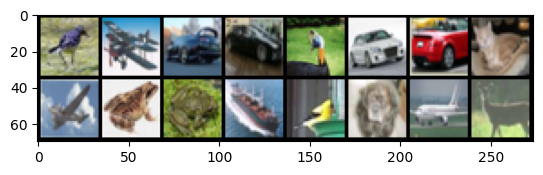

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# show images
imshow(torchvision.utils.make_grid(images))


### A Basic CNN Model

Check out [here](https://madebyollin.github.io/convnet-calculator/) for a helper calculator you can use for the layer dimensions!

### Some basic checks...

In [ ]:
for inputs, labels in train_loader:
    print("The shape of inputs is:", inputs.shape)
    print("The shape of labels is:", labels.shape)
    break

print("Number of classes:", len(train_dataset.classes))

The shape of inputs is: torch.Size([16, 3, 32, 32])
The shape of labels is: torch.Size([16])
Number of classes: 10


### Defining CNN Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=4, stride=2)  # default: stride=1
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size=3) # default: stride=kernel_size
        self.flatten = nn.Flatten(start_dim=1)
        self.fc = nn.Linear(in_features=20, out_features=10) # 20 --> size of out channels, 5*5 is decided by choice
        # of hyperparams of kernel_size, stride and pad

    def forward(self, x):
        outputs = self.mp(self.relu(self.conv(x)))
        outputs = self.mp(outputs)
        outputs = self.fc(self.flatten(outputs))
        return outputs

### Train the CNN

To check if GPU is available and setting up the device variable

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Sending the data to device (CPU or GPU)
cnn = CNN()
cnn.to(device)
criterion = nn.CrossEntropyLoss() # equivalent to applying LogSoftmax() to output and then use NLLLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step

loss_LIST = []

# Epochs 3
for epoch in range(3):
  running_loss = 0.0
  for inputs, labels in train_loader:

      inputs, labels = inputs.to(device), labels.to(device)
      outputs = cnn(inputs) # Feed the network the train data
      optimizer.zero_grad() # We need to reset the optimizer tensor gradient every mini-batch
      loss = criterion(outputs, labels) # this is the average loss for one mini-batch of inputs
      loss.backward() # Do a back propagation
      optimizer.step() # Update the weight using the gradients from back propagation by learning step

      running_loss += loss.item() #get the accumulated loss for each epoch
  loss_LIST.append(running_loss / len(train_loader)) # get the avg loss for each epoch

  # print statistics
  print(f'The loss for Epoch {epoch} is: {running_loss/len(train_loader)}')

The loss for Epoch 0 is: 2.2775036009979246
The loss for Epoch 1 is: 2.20622914188385
The loss for Epoch 2 is: 2.1282063682556154


### Calculate the Accuracy

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images) # shape: torch.Size([10000, 10])
        _, predicted = torch.max(outputs.data, 1) # use max to get the prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}')

Test Accuracy: 26.09
